https://www.andreasjakl.com/easily-create-depth-maps-with-smartphone-ar-part-1/
https://github.com/andijakl/python-depthmaps

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Read image
# Read both images and convert to grayscale
# img1 = cv.imread('Data/graf1.png', cv.IMREAD_GRAYSCALE)
img1 = cv.imread('Data/20230501_205454000_iOS/output_0001.jpg', cv.IMREAD_GRAYSCALE)
# img2 = cv.imread('Data/graf3.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('Data/20230501_205454000_iOS/output_0091.jpg', cv.IMREAD_GRAYSCALE)

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

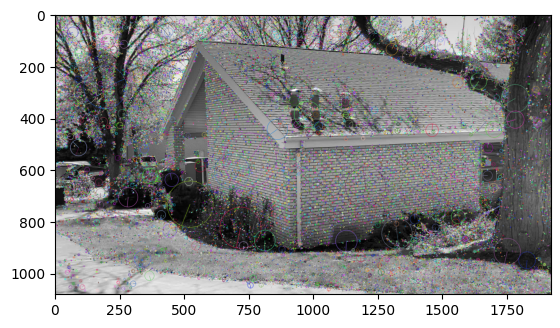

In [3]:

# Visualize keypoints
imgSift = cv.drawKeypoints(
    img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imshow("SIFT Keypoints", imgSift)
cv.waitKey(0)
cv.destroyAllWindows()
plt.imshow(imgSift)
plt.show()

In [95]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

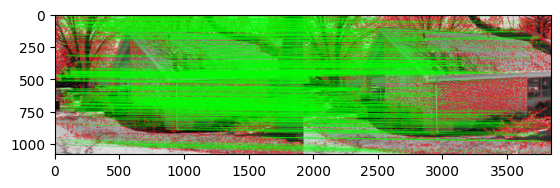

In [109]:
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches, None, **draw_params)

plt.imshow(keypoint_matches)
plt.show()

In [78]:
# Comment or uncomment to use ORB or BEBLID
descriptor = cv.xfeatures2d.BEBLID_create(0.75)
# descriptor = cv.ORB_create()
kpts1, desc1 = descriptor.compute(img1, kp1)
kpts2, desc2 = descriptor.compute(img2, kp2)

In [72]:
# detector = cv.ORB_create(10000)
detector = cv.ORB_create()
kpts1 = detector.detect(img1, None)
kpts2 = detector.detect(img2, None)
descriptor = cv.xfeatures2d.BEBLID_create(0.75)
kpts1, desc1 = descriptor.compute(img1, kpts1)
kpts2, desc2 = descriptor.compute(img2, kpts2)

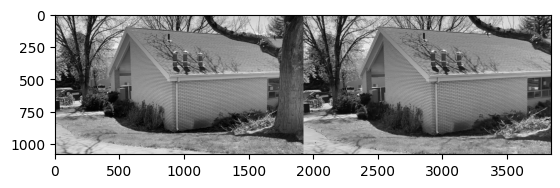

In [84]:
img3 = cv.drawMatches(img1,kpts1,img2,kpts2,None,
                           None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

In [73]:
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)
matched1 = []
matched2 = []
nn_match_ratio = 0.8  # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(kpts1[m.queryIdx])
        matched2.append(kpts2[m.trainIdx])

In [101]:
img3 = cv.drawMatches(img1,matched1,img2,matched2,
                    None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'drawMatches'
> Overload resolution failed:
>  - drawMatches() missing required argument 'outImg' (pos 6)
>  - drawMatches() missing required argument 'outImg' (pos 6)
>  - drawMatches() missing required argument 'outImg' (pos 6)
>  - drawMatches() missing required argument 'outImg' (pos 6)


In [ ]:
# feature_matching = 'bf'
# print("Using: {} feature matcher".format(feature_matching))

# fig = plt.figure(figsize=(20,8))

# if feature_matching == 'bf':
#     matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
#     img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
#                            None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# elif feature_matching == 'knn':
#     matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
#     img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
#                            None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

# plt.imshow(img3)
# plt.show()

In [74]:
# Load homography (geometric transformation between image)
fs = cv.FileStorage("H1to3p.xml", cv.FILE_STORAGE_READ)
homography = fs.getFirstTopLevelNode().mat()
print(f"Homography from img1 to img2:\n{homography}")

Homography from img1 to img2:
[[ 7.6285898e-01 -2.9922929e-01  2.2567123e+02]
 [ 3.3443473e-01  1.0143901e+00 -7.6999973e+01]
 [ 3.4663091e-04 -1.4364524e-05  1.0000000e+00]]


In [75]:
from math import sqrt
inliers1 = []
inliers2 = []
good_matches = []
inlier_threshold = 2.5  # Distance threshold to identify inliers with homography check
for i, m in enumerate(matched1):
    # Create the homogeneous point
    col = np.ones((3, 1), dtype=np.float64)
    col[0:2, 0] = m.pt
    # Project from image 1 to image 2
    col = np.dot(homography, col)
    col /= col[2, 0]
    # Calculate euclidean distance
    dist = sqrt(pow(col[0, 0] - matched2[i].pt[0], 2) + \
                pow(col[1, 0] - matched2[i].pt[1], 2))
    if dist < inlier_threshold:
        good_matches.append(cv.DMatch(len(inliers1), len(inliers2), 0))
        inliers1.append(matched1[i])
        inliers2.append(matched2[i])

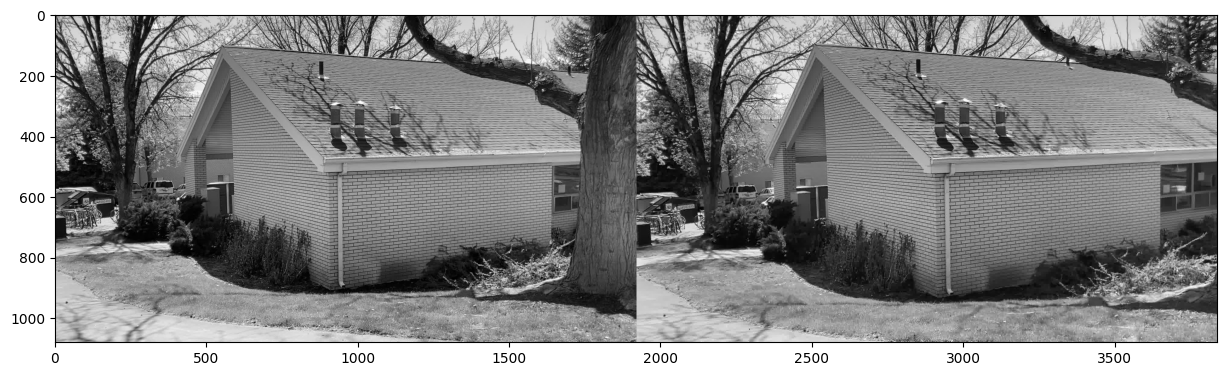

In [76]:
res = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
cv.drawMatches(img1, inliers1, img2, inliers2, good_matches, res)
plt.figure(figsize=(15, 5))
plt.imshow(res)

In [77]:
inlier_ratio = len(inliers1) / float(len(matched1))
print('Matching Results')
print('*******************************')
print('# Keypoints 1:                        \t', len(kpts1))
print('# Keypoints 2:                        \t', len(kpts2))
print('# Matches:                            \t', len(matched1))
print('# Inliers:                            \t', len(inliers1))
print('# Inliers Ratio:                      \t', inlier_ratio)

Matching Results
*******************************
# Keypoints 1:                        	 500
# Keypoints 2:                        	 500
# Matches:                            	 84
# Inliers:                            	 0
# Inliers Ratio:                      	 0.0
